## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


## Set Paths and Load Filenames

In [2]:
import os
import pandas as pd

# Update this path to where your Act1, Act2... folders are saved
BASE_DIR = "data"  # if your data folders are inside 'emotion-classifier/data'

data = []

for act in os.listdir(BASE_DIR):
    act_path = os.path.join(BASE_DIR, act)
    if os.path.isdir(act_path):
        for file in os.listdir(act_path):
            if file.endswith(".wav") or file.endswith(".mp3"):
                label = file.split('_')[0].lower()  # e.g., happy_01.wav => happy
                file_path = os.path.join(act_path, file)
                data.append((file_path, label))

# Create DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Preview data
print(df['label'].value_counts())
df.head()


label
03-01-01-01-01-01-01.wav    1
03-01-02-01-02-02-17.wav    1
03-01-02-01-01-02-17.wav    1
03-01-02-01-01-01-17.wav    1
03-01-01-01-02-02-17.wav    1
                           ..
03-01-08-02-02-01-08.wav    1
03-01-08-02-01-02-08.wav    1
03-01-08-02-01-01-08.wav    1
03-01-08-01-02-02-08.wav    1
03-01-08-02-02-02-24.wav    1
Name: count, Length: 1440, dtype: int64


,file_path,label
0,data\Actor_01\03-01-01-01-01-01-01.wav,03-01-01-01-01-01-01.wav
1,data\Actor_01\03-01-01-01-01-02-01.wav,03-01-01-01-01-02-01.wav
2,data\Actor_01\03-01-01-01-02-01-01.wav,03-01-01-01-02-01-01.wav
3,data\Actor_01\03-01-01-01-02-02-01.wav,03-01-01-01-02-02-01.wav
4,data\Actor_01\03-01-02-01-01-01-01.wav,03-01-02-01-01-01-01.wav


In [3]:
import os

BASE_DIR = "data"

print("Folders inside /data:")
print(os.listdir(BASE_DIR))


Folders inside /data:
['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'archive.zip', 'audio_speech_actors_01-24']


In [4]:
import os
import pandas as pd

emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

BASE_DIR = "data"
data = []

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)
    if os.path.isdir(folder_path) and folder.startswith("Actor"):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                # Get emotion from filename (3rd group)
                emotion_code = file.split("-")[2]
                emotion_label = emotion_map.get(emotion_code)
                file_path = os.path.join(folder_path, file)
                data.append((file_path, emotion_label))

# Create DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])
print(df['label'].value_counts())
df.head()


label
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64


,file_path,label
0,data\Actor_01\03-01-01-01-01-01-01.wav,neutral
1,data\Actor_01\03-01-01-01-01-02-01.wav,neutral
2,data\Actor_01\03-01-01-01-02-01-01.wav,neutral
3,data\Actor_01\03-01-01-01-02-02-01.wav,neutral
4,data\Actor_01\03-01-02-01-01-01-01.wav,calm


In [5]:
import librosa
import numpy as np
from tqdm import tqdm  # for progress bar

def extract_mfcc(file_path, n_mfcc=40, max_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        
        # Pad or truncate to max_len
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [6]:
## Feature Extraction and Label Encoding

In [7]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize lists
X, y = [], []

# Extract MFCC features
for path, label in tqdm(df.values, desc="Extracting MFCCs"):
    mfcc = extract_mfcc(path)
    if mfcc is not None:
        X.append(mfcc)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X for CNN input (add channel dimension)
X = X[..., np.newaxis]  # Shape becomes (samples, 40, 174, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Output summary
print("✅ Feature extraction complete!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y categorical shape:", y_cat.shape)


Extracting MFCCs:   0%|                                                                       | 0/1440 [00:00<?, ?it/s]C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Extracting MFCCs: 100%|███████████████████████████████████████████████████████████

✅ Feature extraction complete!
X shape: (1440, 40, 174, 1)
y shape: (1440,)
y categorical shape: (1440, 8)


In [8]:
## Label Encoding and One-Hot Encoding (Separate)

In [9]:
# Label Encoding and One-Hot Encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the label encoder
label_encoder = LabelEncoder()

# Convert string labels to integers
y_encoded = label_encoder.fit_transform(y)

# Convert integer labels to one-hot encoded format
y_categorical = to_categorical(y_encoded)

# Optional: Print label classes and shape for verification
print("Classes:", label_encoder.classes_)
print("y_encoded shape:", y_encoded.shape)
print("y_categorical shape:", y_categorical.shape)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
y_encoded shape: (1440,)
y_categorical shape: (1440, 8)


In [10]:
##  CNN Model Architecture for Speech Emotion Classification

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import Input

# Define the CNN model
model = Sequential([
    Input(shape=(40, 174, 1)),  # Input shape for MFCCs
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(8, activation='softmax')  # 8 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,752,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,772,488 (10.58 MB)

 Trainable params: 2,772,488 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
## Train-Test Split and Model Training

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)



Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.1367 - loss: 24.3809 - val_accuracy: 0.1732 - val_loss: 2.0794
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.1385 - loss: 2.0895 - val_accuracy: 0.1472 - val_loss: 2.0649
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.1844 - loss: 2.0540 - val_accuracy: 0.1688 - val_loss: 1.9766
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.2448 - loss: 1.9354 - val_accuracy: 0.2165 - val_loss: 1.9080
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.3150 - loss: 1.8174 - val_accuracy: 0.2641 - val_loss: 1.8523
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.3587 - loss: 1.6657 - val_accuracy: 0.2684 - val_loss: 1.8216
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.4235 - loss: 1.5928 - val_accuracy: 0.3550 - val_loss: 1.6903
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.4770 - loss: 1.4053 - val_accuracy: 0

## Training Accuracy & Loss Visualization

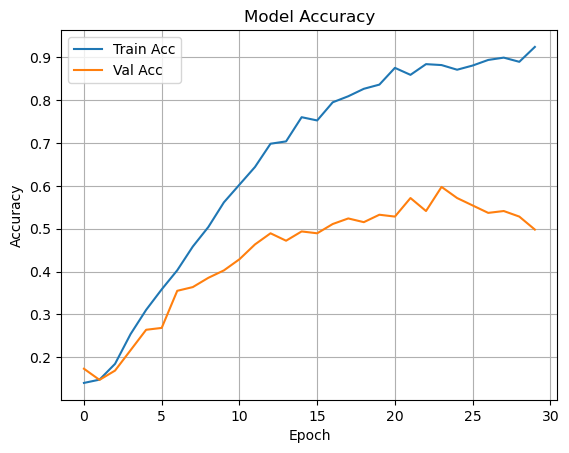

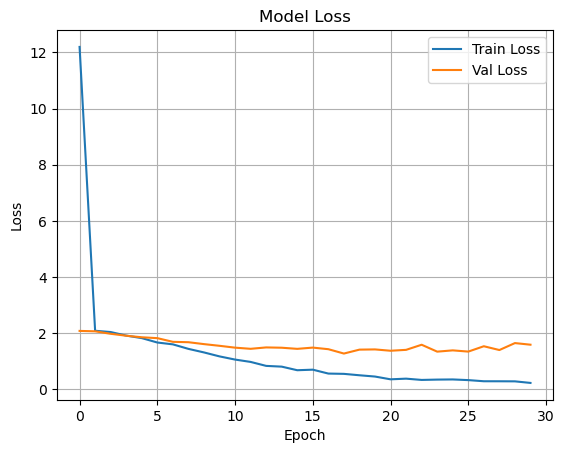

In [14]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


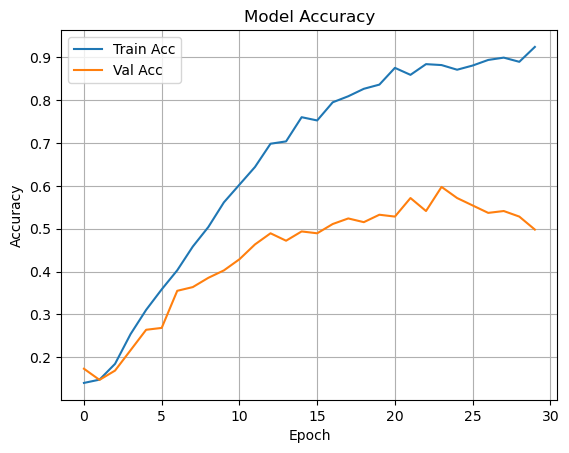

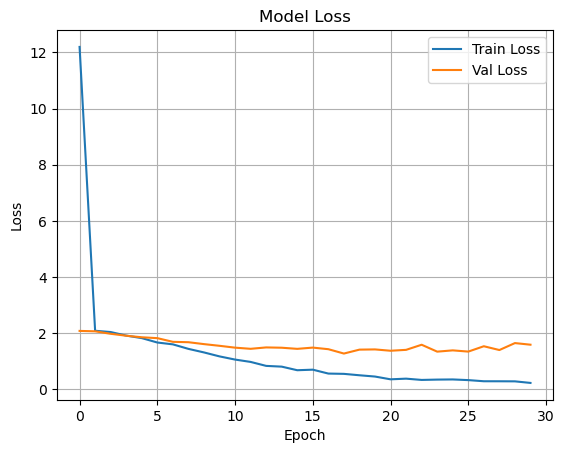

In [15]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate Model Performance on Test Data

In [16]:
# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5572 - loss: 1.6683

🎯 Test Accuracy: 53.47%
📉 Test Loss: 1.7835


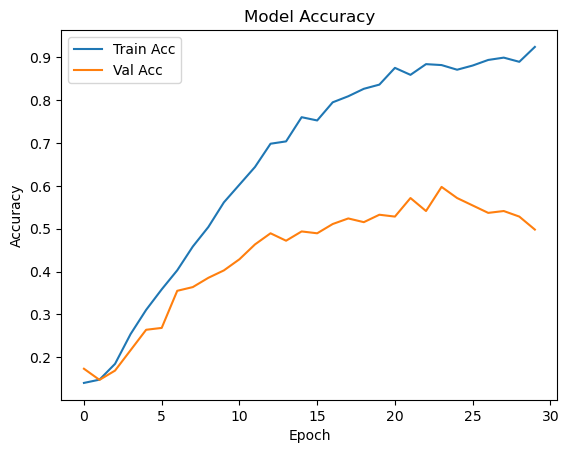

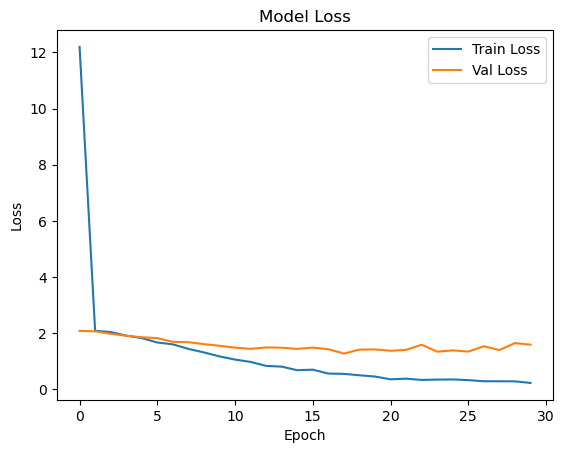

In [17]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Plot Confusion Matrix to Evaluate Class-wise Predictions

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


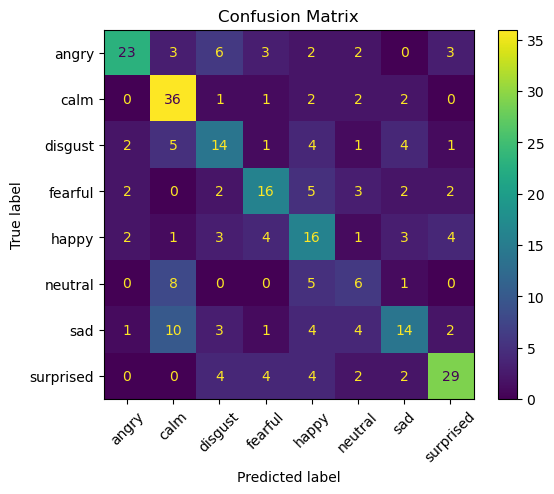

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# Improved CNN 

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     LeakyReLU, Dropout, GlobalAveragePooling2D, Dense)

model = Sequential([
    Input(shape=(40, 174, 1)),

    # Conv Block 1
    Conv2D(32, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 2
    Conv2D(64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 3
    Conv2D(128, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Optional 4th Conv Block (for larger datasets)
    Conv2D(256, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Global Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully Connected
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='softmax')  # 8 emotion classes
])


In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 40, 174, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 174, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 40, 174, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 20, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 10, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 21, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 21, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 5, 21, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 10, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 423,688 (1.62 MB)

 Trainable params: 422,728 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 462ms/step - accuracy: 0.1379 - loss: 2.2399 - val_accuracy: 0.0996 - val_loss: 2.6463
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - accuracy: 0.2021 - loss: 1.9799 - val_accuracy: 0.0996 - val_loss: 2.9101
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 445ms/step - accuracy: 0.2307 - loss: 1.9236 - val_accuracy: 0.1169 - val_loss: 2.3316
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 445ms/step - accuracy: 0.2637 - loss: 1.8483 - val_accuracy: 0.1342 - val_loss: 2.0676
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - accuracy: 0.2647 - loss: 1.8040 - val_accuracy: 0.1472 - val_loss: 2.1114
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - accuracy: 0.3412 - loss: 1.7062 - val_accuracy: 0.1255 - val_loss: 2.4514
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step - accuracy: 0.3434 - loss: 1.7049 - val_accuracy: 0.3074 - val_loss: 1.8564
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - accuracy: 0.3505 - loss: 1.6607 - val_accu

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.3766 - loss: 1.7864

🎯 Test Accuracy: 37.15%
📉 Test Loss: 1.7143


In [25]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y_cat shape:", y_cat.shape)
print("Unique labels:", np.unique(y))
print("Categorical sample (first):", y_cat[0])


X shape: (1440, 40, 174, 1)
y shape: (1440,)
y_cat shape: (1440, 8)
Unique labels: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Categorical sample (first): [0. 0. 0. 0. 0. 1. 0. 0.]


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     LeakyReLU, Dropout, Reshape, Bidirectional,
                                     LSTM, Dense, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

inp = Input(shape=(40, 174, 1))

x = Conv2D(32, (3, 3), padding='same')(inp)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Shape before RNN: (10, 43, 64)
x = Reshape((10, -1))(x)  # reshape for LSTM input

x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(8, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 40, 174, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 40, 174, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 40, 174, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 40, 174, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 20, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 20, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 2752)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │       1,442,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,470,280 (5.61 MB)

 Trainable params: 1,470,088 (5.61 MB)

 Non-trainable params: 192 (768.00 B)

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Dropout,
                                     Reshape, Bidirectional, LSTM, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Normalize input
X = X.astype('float32')
X = (X - np.mean(X)) / np.std(X)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Define model
input_layer = Input(shape=(40, 174, 1))

x = Conv2D(32, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Reshape for RNN
x = Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)

x = Bidirectional(LSTM(64))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0003),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step - accuracy: 0.1350 - loss: 2.1314 - val_accuracy: 0.1299 - val_loss: 2.0710 - learning_rate: 3.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.1779 - loss: 2.0160 - val_accuracy: 0.2468 - val_loss: 2.0447 - learning_rate: 3.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.2184 - loss: 1.9968 - val_accuracy: 0.2381 - val_loss: 2.0251 - learning_rate: 3.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.2609 - loss: 1.9213 - val_accuracy: 0.1775 - val_loss: 2.0445 - learning_rate: 3.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.2703 - loss: 1.8578 - val_accuracy: 0.1775 - val_loss: 2.1358 - learning_rate: 3.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.3224 - loss: 1.7668 - val_accuracy: 0.1775 - val_loss: 2.1504 - learning_rate: 3.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - acc

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, 
                                     Reshape, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import os

# ✅ Set seeds to stabilize results
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# ✅ Normalize input
X = (X - np.mean(X)) / np.std(X)

# ✅ Encode string labels to integers
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = to_categorical(y_int, num_classes=8)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=seed, stratify=y_cat)

# ✅ Model definition
input_layer = Input(shape=(40, 174, 1), name='input_layer')

x = Conv2D(32, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # (20, 87)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # (10, 43)

x = Reshape((10, 43 * 64))(x)  # Reshape to (10, 2752)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

# ✅ Compile
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# ✅ Train
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# ✅ Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 473ms/step - accuracy: 0.1364 - loss: 2.5516 - val_accuracy: 0.1342 - val_loss: 2.0643 - learning_rate: 3.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - accuracy: 0.2464 - loss: 2.0975 - val_accuracy: 0.1342 - val_loss: 2.0697 - learning_rate: 3.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.3060 - loss: 1.8753 - val_accuracy: 0.1255 - val_loss: 2.0638 - learning_rate: 3.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.4233 - loss: 1.7077 - val_accuracy: 0.1775 - val_loss: 2.0632 - learning_rate: 3.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - accuracy: 0.4508 - loss: 1.6173 - val_accuracy: 0.1818 - val_loss: 2.0667 - learning_rate: 3.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.5023 - loss: 1.5102 - val_accuracy: 0.2381 - val_loss: 2.0678 - learning_rate: 3.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - acc

In [29]:
## Save the Trained Model

In [30]:
# 📦 Cell 11: Save Trained Models in Different Formats

# Save as HDF5 (standard Keras format)
model.save("best_model.h5")

# Save a smaller version for lightweight testing
model.save("emotion_model_v1.h5")

# Save in the modern .keras format
model.save("emotion_model.keras")

print("✅ Models saved: best_model.h5, emotion_model_v1.h5, emotion_model.keras")


✅ Models saved: best_model.h5, emotion_model_v1.h5, emotion_model.keras


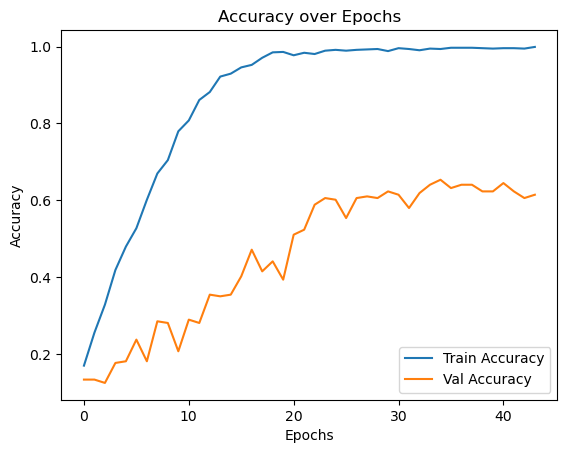

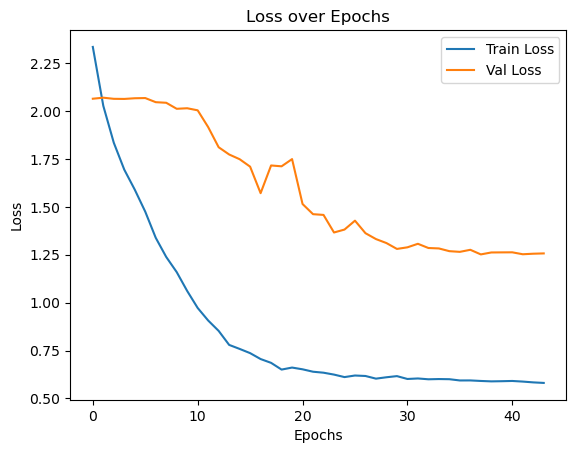

In [31]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


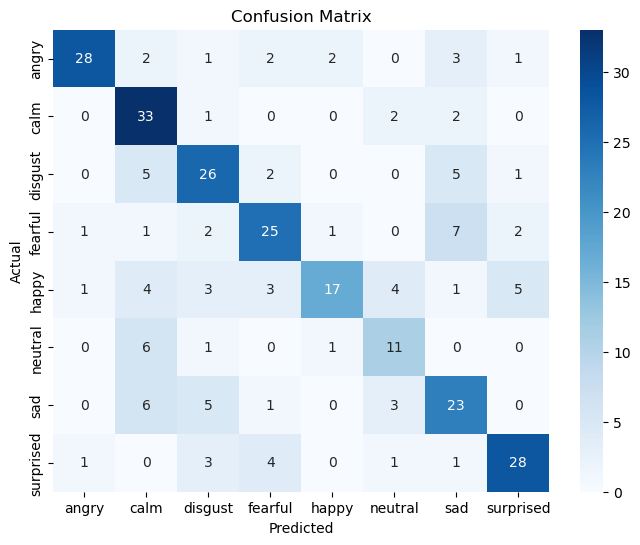

              precision    recall  f1-score   support

       angry       0.90      0.72      0.80        39
        calm       0.58      0.87      0.69        38
     disgust       0.62      0.67      0.64        39
     fearful       0.68      0.64      0.66        39
       happy       0.81      0.45      0.58        38
     neutral       0.52      0.58      0.55        19
         sad       0.55      0.61      0.57        38
   surprised       0.76      0.74      0.75        38

    accuracy                           0.66       288
   macro avg       0.68      0.66      0.66       288
weighted avg       0.69      0.66      0.66       288



In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict classes
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


### Detailed Evaluation (Confusion Matrix + Classification Report)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


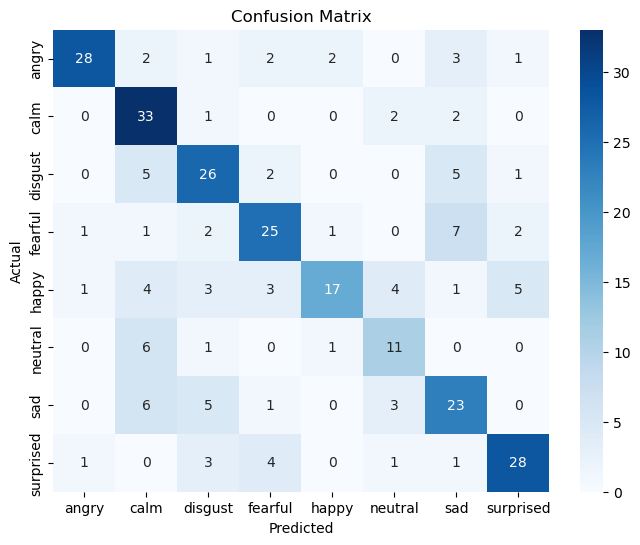


📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.90      0.72      0.80        39
        calm       0.58      0.87      0.69        38
     disgust       0.62      0.67      0.64        39
     fearful       0.68      0.64      0.66        39
       happy       0.81      0.45      0.58        38
     neutral       0.52      0.58      0.55        19
         sad       0.55      0.61      0.57        38
   surprised       0.76      0.74      0.75        38

    accuracy                           0.66       288
   macro avg       0.68      0.66      0.66       288
weighted avg       0.69      0.66      0.66       288



In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


### Plot Accuracy & Loss Over Epochs

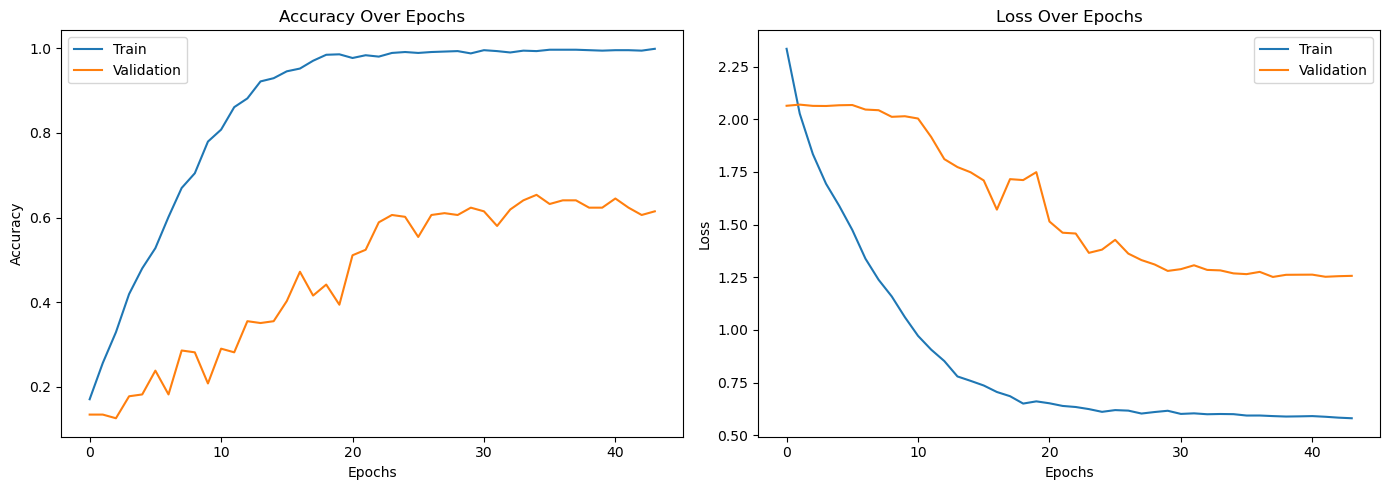

In [34]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Test Sample Predictions

In [35]:
import random

# Pick random samples from test set
num_samples = 10
sample_indices = random.sample(range(X_test.shape[0]), num_samples)

#  Predict on selected samples
sample_X = X_test[sample_indices]
sample_y_true = np.argmax(y_test[sample_indices], axis=1)
sample_y_pred = np.argmax(model.predict(sample_X), axis=1)

print(" Emotion Prediction Results:\n")
for i, idx in enumerate(sample_indices):
    true_label = le.classes_[sample_y_true[i]]
    pred_label = le.classes_[sample_y_pred[i]]
    print(f"Sample {i+1}:  Actual: {true_label}  |   Predicted: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
 Emotion Prediction Results:

Sample 1:  Actual: fearful  |   Predicted: fearful
Sample 2:  Actual: sad  |   Predicted: sad
Sample 3:  Actual: disgust  |   Predicted: disgust
Sample 4:  Actual: calm  |   Predicted: calm
Sample 5:  Actual: fearful  |   Predicted: fearful
Sample 6:  Actual: surprised  |   Predicted: surprised
Sample 7:  Actual: fearful  |   Predicted: sad
Sample 8:  Actual: disgust  |   Predicted: sad
Sample 9:  Actual: happy  |   Predicted: fearful
Sample 10:  Actual: disgust  |   Predicted: disgust


### Run the Prediction Comparison Cell

In [36]:
import random

#  Pick random samples from test set
num_samples = 10
sample_indices = random.sample(range(X_test.shape[0]), num_samples)

#  Predict on selected samples
sample_X = X_test[sample_indices]
sample_y_true = np.argmax(y_test[sample_indices], axis=1)
sample_y_pred = np.argmax(model.predict(sample_X), axis=1)

print(" Emotion Prediction Results:\n")
for i, idx in enumerate(sample_indices):
    true_label = le.classes_[sample_y_true[i]]
    pred_label = le.classes_[sample_y_pred[i]]
    print(f"Sample {i+1}:  Actual: {true_label}  |  🤖 Predicted: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
 Emotion Prediction Results:

Sample 1:  Actual: surprised  |  🤖 Predicted: surprised
Sample 2:  Actual: fearful  |  🤖 Predicted: fearful
Sample 3:  Actual: angry  |  🤖 Predicted: angry
Sample 4:  Actual: angry  |  🤖 Predicted: angry
Sample 5:  Actual: disgust  |  🤖 Predicted: disgust
Sample 6:  Actual: neutral  |  🤖 Predicted: neutral
Sample 7:  Actual: sad  |  🤖 Predicted: disgust
Sample 8:  Actual: fearful  |  🤖 Predicted: fearful
Sample 9:  Actual: sad  |  🤖 Predicted: sad
Sample 10:  Actual: fearful  |  🤖 Predicted: fearful


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


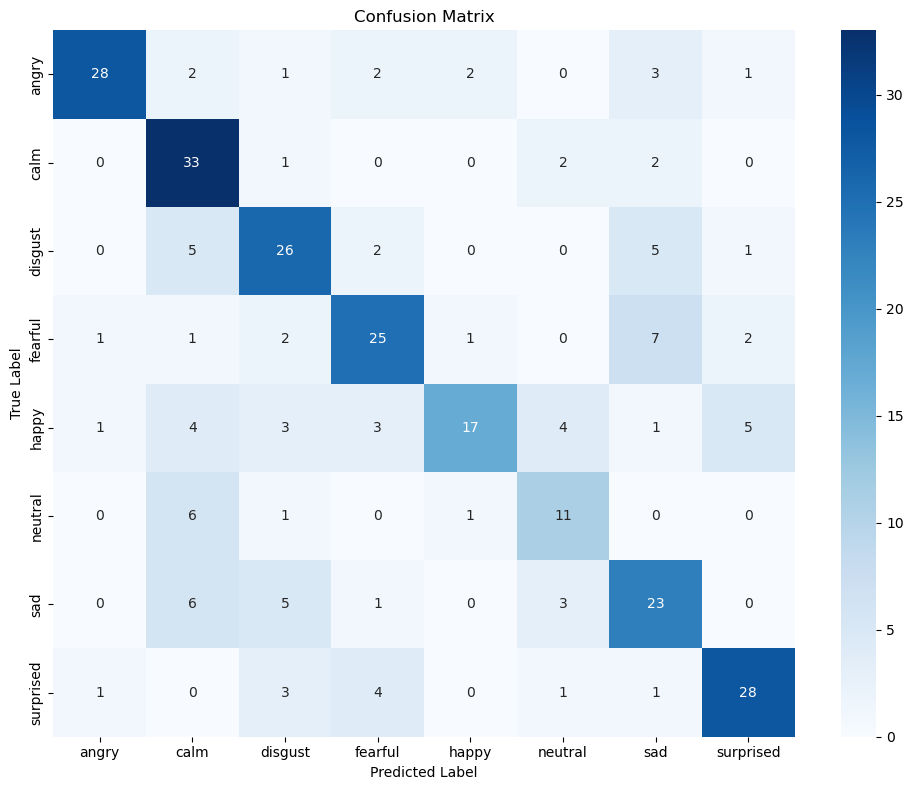

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
emotion_labels = le.classes_

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix")  # Removed emoji to avoid warning
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [38]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print("Macro F1 Score:", macro_f1)
print("Weighted F1 Score:", weighted_f1)


Accuracy: 0.6631944444444444

Classification Report:
               precision    recall  f1-score   support

       angry       0.90      0.72      0.80        39
        calm       0.58      0.87      0.69        38
     disgust       0.62      0.67      0.64        39
     fearful       0.68      0.64      0.66        39
       happy       0.81      0.45      0.58        38
     neutral       0.52      0.58      0.55        19
         sad       0.55      0.61      0.57        38
   surprised       0.76      0.74      0.75        38

    accuracy                           0.66       288
   macro avg       0.68      0.66      0.66       288
weighted avg       0.69      0.66      0.66       288

Macro F1 Score: 0.6553180925870861
Weighted F1 Score: 0.662731146499855


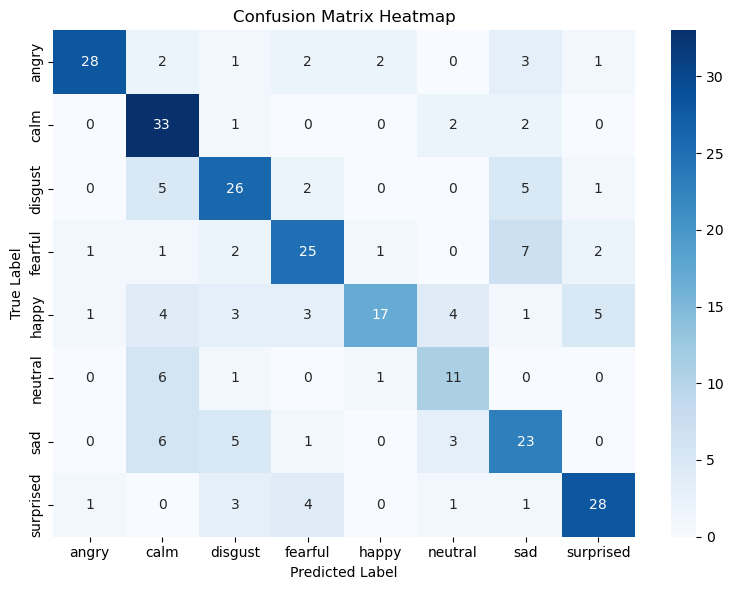


✅ Confusion Matrix (Raw Values):

           angry        calm     disgust     fearful       happy     neutral         sad   surprised
     angry          28           2           1           2           2           0           3           1
      calm           0          33           1           0           0           2           2           0
   disgust           0           5          26           2           0           0           5           1
   fearful           1           1           2          25           1           0           7           2
     happy           1           4           3           3          17           4           1           5
   neutral           0           6           1           0           1          11           0           0
       sad           0           6           5           1           0           3          23           0
 surprised           1           0           3           4           0           1           1          28


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define emotion labels from LabelEncoder
emotion_labels = label_encoder.classes_

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Print matrix as plain text
print("\n✅ Confusion Matrix (Raw Values):\n")
print("      " + "  ".join(f"{label:>10}" for label in emotion_labels))
for i, row in enumerate(cm):
    print(f"{emotion_labels[i]:>10}  " + "  ".join(f"{val:>10}" for val in row))


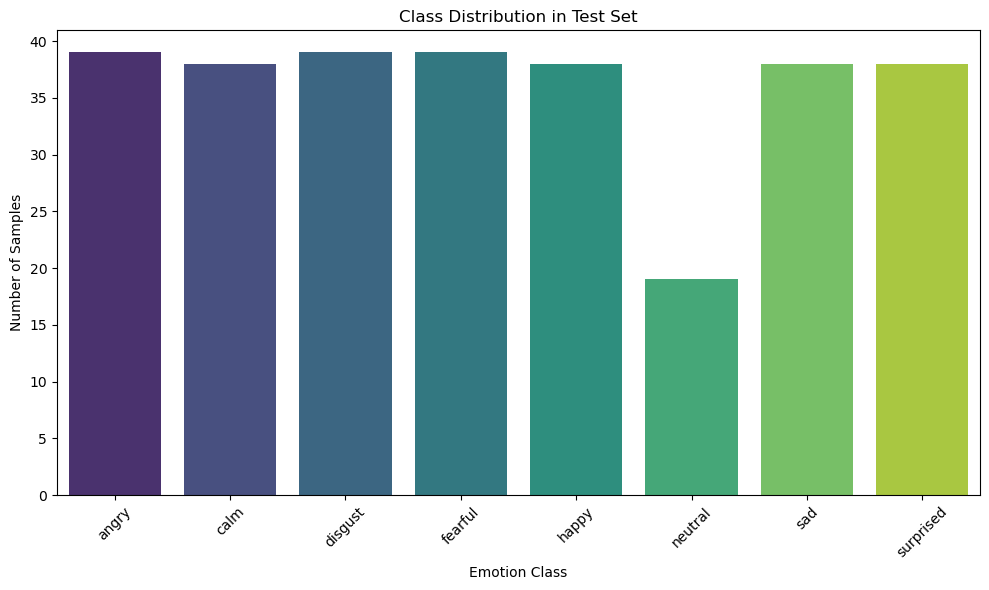

{'angry': 39,
 'calm': 38,
 'disgust': 39,
 'fearful': 39,
 'happy': 38,
 'neutral': 19,
 'sad': 38,
 'surprised': 38}

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert y_test from one-hot to label indices if needed
y_true = np.argmax(y_test, axis=1)

# Emotion labels (already from LabelEncoder)
emotion_labels = le.classes_

# Count each class
unique, counts = np.unique(y_true, return_counts=True)
class_distribution = dict(zip([emotion_labels[i] for i in unique], counts))

# Plot class distribution (Future-proofed)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), hue=list(class_distribution.keys()), legend=False, palette='viridis')
plt.title("Class Distribution in Test Set")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_distribution